In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
!nvidia-smi


Thu Jul 24 19:18:01 2025       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 550.54.15              Driver Version: 550.54.15      CUDA Version: 12.4     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  Tesla T4                       Off |   00000000:00:04.0 Off |                    0 |
| N/A   34C    P8              9W /   70W |       0MiB /  15360MiB |      0%      Default |
|                                         |                        |                  N/A |
+-----------------------------------------+-----

In [3]:
import os

correct_path = '/content/drive/MyDrive/Medical_Data/archive/chest_xray/chest_xray_split'
print(os.listdir(correct_path))

['train', 'val', 'test']


In [4]:
print("Train folders:", os.listdir(correct_path + '/train'))
print("Val folders:", os.listdir(correct_path + '/val'))
print("Test folders:", os.listdir(correct_path + '/test'))

Train folders: ['PNEUMONIA', 'NORMAL']
Val folders: ['PNEUMONIA', 'NORMAL']
Test folders: ['PNEUMONIA', 'NORMAL']


In [5]:
import os

base_path = '/content/drive/MyDrive/Medical_Data/archive/chest_xray/chest_xray_split'

splits = ['train', 'val', 'test']
classes = ['PNEUMONIA', 'NORMAL']

for split in splits:
    for cls in classes:
        folder = os.path.join(base_path, split, cls)
        count = len([f for f in os.listdir(folder) if f.lower().endswith(('.jpg', '.jpeg', '.png'))])
        print(f"{split.capitalize()} - {cls}: {count} images")


Train - PNEUMONIA: 3818 images
Train - NORMAL: 1403 images
Val - PNEUMONIA: 1135 images
Val - NORMAL: 418 images
Test - PNEUMONIA: 1141 images
Test - NORMAL: 415 images


In [ ]:
!pip install transformers datasets torchvision


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 4.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 84.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 72.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 57.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 5.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 12.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 7.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 6.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 93.8 MB/s eta 0:00:00
  Attempting uninstall: nvidia-nvjitlink-cu12
    Found existing installation: nvidia-nvjitlink-cu12 12.5.82
    Uninstalling nvidia-nvjitlink-cu12-12.5.82:
      Successfully uninstalled nvidia-nvjitlin

In [ ]:
import os
import torch
from torch import nn
from torchvision import transforms, datasets
from torch.utils.data import DataLoader
from transformers import ViTForImageClassification, ViTFeatureExtractor, Trainer, TrainingArguments
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from datasets import Dataset
import numpy as np
from PIL import Image
from tqdm import tqdm

In [ ]:
# ⚠️ Set the path to your Google Drive dataset
base_path = '/content/drive/MyDrive/Medical_Data/archive/chest_xray/chest_xray_split'

# 🧪 Image size & transforms
image_size = 224
feature_extractor = ViTFeatureExtractor.from_pretrained('google/vit-base-patch16-224')

# Train augmentation
train_transform = transforms.Compose([
    transforms.Resize((image_size, image_size)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(10),
    transforms.ColorJitter(brightness=0.1, contrast=0.1),
    transforms.ToTensor()
])

# Validation/test transform (no augmentation)
val_transform = transforms.Compose([
    transforms.Resize((image_size, image_size)),
    transforms.ToTensor()
])


/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


preprocessor_config.json:   0%|          | 0.00/160 [00:00<?, ?B/s]

/usr/local/lib/python3.11/dist-packages/transformers/models/vit/feature_extraction_vit.py:30: FutureWarning: The class ViTFeatureExtractor is deprecated and will be removed in version 5 of Transformers. Please use ViTImageProcessor instead.
  warnings.warn(


In [ ]:
def load_data(split, transform):
    dataset = datasets.ImageFolder(os.path.join(base_path, split), transform=transform)
    return dataset

train_dataset = load_data('train', train_transform)
val_dataset   = load_data('val', val_transform)
test_dataset  = load_data('test', val_transform)

# Class labels
labels_map = train_dataset.class_to_idx  # {'NORMAL': 0, 'PNEUMONIA': 1}
print(labels_map)

# ⚖️ Class counts for optional weighting
from collections import Counter
counts = Counter(train_dataset.targets)
print(f"Train class counts: {counts}")


{'NORMAL': 0, 'PNEUMONIA': 1}
Train class counts: Counter({1: 3818, 0: 1403})


In [ ]:
from transformers import ViTForImageClassification

model = ViTForImageClassification.from_pretrained(
    "google/vit-base-patch16-224",
    num_labels=2,
    ignore_mismatched_sizes=True  # ✅ This replaces the classifier head
)


config.json: 0.00B [00:00, ?B/s]

model.safetensors:   0%|          | 0.00/346M [00:00<?, ?B/s]

Some weights of ViTForImageClassification were not initialized from the model checkpoint at google/vit-base-patch16-224 and are newly initialized because the shapes did not match:
- classifier.bias: found shape torch.Size([1000]) in the checkpoint and torch.Size([2]) in the model instantiated
- classifier.weight: found shape torch.Size([1000, 768]) in the checkpoint and torch.Size([2, 768]) in the model instantiated
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [ ]:
# Wrap into DataLoader
train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True)
val_loader   = DataLoader(val_dataset, batch_size=16)

# Use GPU if available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

# Optimizer & Loss
optimizer = torch.optim.AdamW(model.parameters(), lr=2e-5)
loss_fn = nn.CrossEntropyLoss()

# 🔁 Training loop
def train(model, train_loader, val_loader, epochs=10):
    for epoch in range(epochs):
        model.train()
        total_loss = 0
        for images, labels in tqdm(train_loader, desc=f"Epoch {epoch+1}/{epochs}"):
            images, labels = images.to(device), labels.to(device)
            inputs = feature_extractor(images=images, return_tensors="pt").to(device)
            outputs = model(**inputs, labels=labels)
            loss = outputs.loss
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            total_loss += loss.item()

        print(f"✅ Epoch {epoch+1} Loss: {total_loss/len(train_loader):.4f}")
        evaluate(model, val_loader)

# 📊 Validation metrics
def evaluate(model, val_loader):
    model.eval()
    preds, true = [], []
    with torch.no_grad():
        for images, labels in val_loader:
            images = images.to(device)
            inputs = feature_extractor(images=images, return_tensors="pt").to(device)
            outputs = model(**inputs)
            logits = outputs.logits
            pred_labels = torch.argmax(logits, dim=1).cpu().numpy()
            preds.extend(pred_labels)
            true.extend(labels.numpy())
    acc = accuracy_score(true, preds)
    prec = precision_score(true, preds)
    rec = recall_score(true, preds)
    f1 = f1_score(true, preds)
    print(f"🎯 Accuracy: {acc:.4f}, Precision: {prec:.4f}, Recall: {rec:.4f}, F1: {f1:.4f}")


In [ ]:
train(model, train_loader, val_loader, epochs=15)


Epoch 1/15: 100%|██████████| 327/327 [19:20<00:00,  3.55s/it]


✅ Epoch 1 Loss: 0.5895
🎯 Accuracy: 0.7308, Precision: 0.7308, Recall: 1.0000, F1: 0.8445


Epoch 2/15: 100%|██████████| 327/327 [03:40<00:00,  1.49it/s]


✅ Epoch 2 Loss: 0.5875
🎯 Accuracy: 0.7308, Precision: 0.7308, Recall: 1.0000, F1: 0.8445


Epoch 3/15: 100%|██████████| 327/327 [03:38<00:00,  1.49it/s]


✅ Epoch 3 Loss: 0.5836
🎯 Accuracy: 0.7308, Precision: 0.7308, Recall: 1.0000, F1: 0.8445


Epoch 4/15: 100%|██████████| 327/327 [03:38<00:00,  1.50it/s]


✅ Epoch 4 Loss: 0.5859
🎯 Accuracy: 0.7308, Precision: 0.7308, Recall: 1.0000, F1: 0.8445


Epoch 5/15: 100%|██████████| 327/327 [03:37<00:00,  1.50it/s]


✅ Epoch 5 Loss: 0.5834
🎯 Accuracy: 0.7308, Precision: 0.7308, Recall: 1.0000, F1: 0.8445


Epoch 6/15: 100%|██████████| 327/327 [03:37<00:00,  1.50it/s]


✅ Epoch 6 Loss: 0.5835
🎯 Accuracy: 0.7308, Precision: 0.7308, Recall: 1.0000, F1: 0.8445


Epoch 7/15: 100%|██████████| 327/327 [03:37<00:00,  1.50it/s]


✅ Epoch 7 Loss: 0.5838
🎯 Accuracy: 0.7308, Precision: 0.7308, Recall: 1.0000, F1: 0.8445


Epoch 8/15: 100%|██████████| 327/327 [03:38<00:00,  1.50it/s]


✅ Epoch 8 Loss: 0.5849
🎯 Accuracy: 0.7308, Precision: 0.7308, Recall: 1.0000, F1: 0.8445


Epoch 9/15: 100%|██████████| 327/327 [03:38<00:00,  1.50it/s]


✅ Epoch 9 Loss: 0.5845
🎯 Accuracy: 0.7308, Precision: 0.7308, Recall: 1.0000, F1: 0.8445


Epoch 10/15: 100%|██████████| 327/327 [03:39<00:00,  1.49it/s]


✅ Epoch 10 Loss: 0.5845
🎯 Accuracy: 0.7308, Precision: 0.7308, Recall: 1.0000, F1: 0.8445


Epoch 11/15: 100%|██████████| 327/327 [03:39<00:00,  1.49it/s]


✅ Epoch 11 Loss: 0.5844
🎯 Accuracy: 0.7308, Precision: 0.7308, Recall: 1.0000, F1: 0.8445


Epoch 12/15: 100%|██████████| 327/327 [03:38<00:00,  1.50it/s]


✅ Epoch 12 Loss: 0.5838
🎯 Accuracy: 0.7308, Precision: 0.7308, Recall: 1.0000, F1: 0.8445


Epoch 13/15: 100%|██████████| 327/327 [03:38<00:00,  1.50it/s]


✅ Epoch 13 Loss: 0.5839
🎯 Accuracy: 0.7308, Precision: 0.7308, Recall: 1.0000, F1: 0.8445


Epoch 14/15: 100%|██████████| 327/327 [03:38<00:00,  1.50it/s]


✅ Epoch 14 Loss: 0.5831


In [ ]:
# ✅ ViT Training from Scratch – With Cosine LR Scheduler and Resume (One Cell)
import os, json, torch, numpy as np
from tqdm import tqdm
from torch import nn
from torchvision import transforms, datasets
from torch.utils.data import DataLoader
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from transformers import ViTConfig, ViTForImageClassification, ViTFeatureExtractor, get_cosine_schedule_with_warmup

# ---------------- Step 2: Config ---------------- #
base_path = '/content/drive/MyDrive/Medical_Data/archive/chest_xray/chest_xray_split'
history_path = '/content/drive/MyDrive/ViT_scratch_history.json'
model_path = '/content/drive/MyDrive/ViT_scratch_final.pth'

image_size = 224
batch_size = 16
total_epochs = 15
lr = 1e-3
weight_decay = 0.01

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("✅ Using device:", device)

# ---------------- Step 3: Transforms & Data ---------------- #
feature_extractor = ViTFeatureExtractor.from_pretrained("google/vit-base-patch16-224")

train_transform = transforms.Compose([
    transforms.Resize((image_size, image_size)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(10),
    transforms.ColorJitter(brightness=0.1, contrast=0.1),
    transforms.ToTensor()
])

val_transform = transforms.Compose([
    transforms.Resize((image_size, image_size)),
    transforms.ToTensor()
])

train_dataset = datasets.ImageFolder(os.path.join(base_path, 'train'), transform=train_transform)
val_dataset   = datasets.ImageFolder(os.path.join(base_path, 'val'), transform=val_transform)
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader   = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
class_names = train_dataset.classes
print("🧾 Classes:", class_names)

# ---------------- Step 4: ViT from Scratch + Optimizer + Scheduler ---------------- #
config = ViTConfig(image_size=image_size, num_labels=2)
model = ViTForImageClassification(config).to(device)

optimizer = torch.optim.AdamW(model.parameters(), lr=lr, weight_decay=weight_decay)
num_training_steps = len(train_loader) * total_epochs
warmup_steps = int(0.1 * num_training_steps)
scheduler = get_cosine_schedule_with_warmup(optimizer, num_warmup_steps=warmup_steps, num_training_steps=num_training_steps)

loss_fn = nn.CrossEntropyLoss()

# Resume support
start_epoch = 0
history = {"train_loss": [], "val_accuracy": [], "val_precision": [], "val_recall": [], "val_f1": []}
if os.path.exists(model_path):
    print("🔁 Resuming from checkpoint...")
    model.load_state_dict(torch.load(model_path, map_location=device))
    if os.path.exists(history_path):
        with open(history_path, 'r') as f:
            history = json.load(f)
            start_epoch = len(history["train_loss"])
    print(f"🔁 Resumed from epoch {start_epoch}/{total_epochs}")

# ---------------- Step 5: Evaluation Function ---------------- #
def evaluate(model, loader):
    model.eval()
    all_preds, all_labels = [], []
    with torch.no_grad():
        for images, labels in loader:
            images, labels = images.to(device), labels.to(device)
            inputs = feature_extractor(images=images, return_tensors="pt").to(device)
            outputs = model(**inputs)
            preds = torch.argmax(outputs.logits, dim=1)
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())
    acc  = accuracy_score(all_labels, all_preds)
    prec = precision_score(all_labels, all_preds)
    rec  = recall_score(all_labels, all_preds)
    f1   = f1_score(all_labels, all_preds)
    return acc, prec, rec, f1

# ---------------- Step 6: Training Loop ---------------- #
for epoch in range(start_epoch, total_epochs):
    model.train()
    running_loss = 0.0
    for images, labels in tqdm(train_loader, desc=f"Epoch {epoch+1}/{total_epochs}"):
        images, labels = images.to(device), labels.to(device)
        inputs = feature_extractor(images=images, return_tensors="pt").to(device)
        outputs = model(**inputs, labels=labels)
        loss = outputs.loss
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        scheduler.step()
        running_loss += loss.item()
    avg_loss = running_loss / len(train_loader)
    acc, prec, rec, f1 = evaluate(model, val_loader)
    history["train_loss"].append(avg_loss)
    history["val_accuracy"].append(acc)
    history["val_precision"].append(prec)
    history["val_recall"].append(rec)
    history["val_f1"].append(f1)
    with open(history_path, 'w') as f:
        json.dump(history, f)
    torch.save(model.state_dict(), model_path)
    print(f"\n✅ Epoch {epoch+1} Complete:")
    print(f"   🔻 Loss     : {avg_loss:.4f}")
    print(f"   🎯 Accuracy : {acc:.4f}")
    print(f"   🎯 Precision: {prec:.4f}")
    print(f"   🔁 Recall   : {rec:.4f}")
    print(f"   📈 F1 Score : {f1:.4f}")

# ---------------- Step 7: Final Status ---------------- #
print("✅ Training complete. Model + history saved to Drive.")


✅ Using device: cuda


/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


preprocessor_config.json:   0%|          | 0.00/160 [00:00<?, ?B/s]

/usr/local/lib/python3.11/dist-packages/transformers/models/vit/feature_extraction_vit.py:30: FutureWarning: The class ViTFeatureExtractor is deprecated and will be removed in version 5 of Transformers. Please use ViTImageProcessor instead.
  warnings.warn(


🧾 Classes: ['NORMAL', 'PNEUMONIA']


Epoch 1/15: 100%|██████████| 327/327 [20:52<00:00,  3.83s/it]



✅ Epoch 1 Complete:
   🔻 Loss     : 0.6290
   🎯 Accuracy : 0.7308
   🎯 Precision: 0.7308
   🔁 Recall   : 1.0000
   📈 F1 Score : 0.8445


Epoch 2/15: 100%|██████████| 327/327 [03:22<00:00,  1.62it/s]



✅ Epoch 2 Complete:
   🔻 Loss     : 0.6003
   🎯 Accuracy : 0.7308
   🎯 Precision: 0.7308
   🔁 Recall   : 1.0000
   📈 F1 Score : 0.8445


Epoch 3/15: 100%|██████████| 327/327 [03:31<00:00,  1.55it/s]



✅ Epoch 3 Complete:
   🔻 Loss     : 0.5911
   🎯 Accuracy : 0.7308
   🎯 Precision: 0.7308
   🔁 Recall   : 1.0000
   📈 F1 Score : 0.8445


Epoch 4/15: 100%|██████████| 327/327 [03:32<00:00,  1.54it/s]



✅ Epoch 4 Complete:
   🔻 Loss     : 0.5881
   🎯 Accuracy : 0.7308
   🎯 Precision: 0.7308
   🔁 Recall   : 1.0000
   📈 F1 Score : 0.8445


Epoch 5/15: 100%|██████████| 327/327 [03:32<00:00,  1.54it/s]



✅ Epoch 5 Complete:
   🔻 Loss     : 0.5854
   🎯 Accuracy : 0.7308
   🎯 Precision: 0.7308
   🔁 Recall   : 1.0000
   📈 F1 Score : 0.8445


Epoch 6/15: 100%|██████████| 327/327 [03:32<00:00,  1.54it/s]



✅ Epoch 6 Complete:
   🔻 Loss     : 0.5861
   🎯 Accuracy : 0.7308
   🎯 Precision: 0.7308
   🔁 Recall   : 1.0000
   📈 F1 Score : 0.8445


Epoch 7/15: 100%|██████████| 327/327 [03:32<00:00,  1.54it/s]



✅ Epoch 7 Complete:
   🔻 Loss     : 0.5853
   🎯 Accuracy : 0.7308
   🎯 Precision: 0.7308
   🔁 Recall   : 1.0000
   📈 F1 Score : 0.8445


Epoch 8/15: 100%|██████████| 327/327 [03:32<00:00,  1.54it/s]



✅ Epoch 8 Complete:
   🔻 Loss     : 0.5834
   🎯 Accuracy : 0.7308
   🎯 Precision: 0.7308
   🔁 Recall   : 1.0000
   📈 F1 Score : 0.8445


Epoch 9/15: 100%|██████████| 327/327 [03:32<00:00,  1.54it/s]



✅ Epoch 9 Complete:
   🔻 Loss     : 0.5831
   🎯 Accuracy : 0.7308
   🎯 Precision: 0.7308
   🔁 Recall   : 1.0000
   📈 F1 Score : 0.8445


Epoch 10/15: 100%|██████████| 327/327 [03:32<00:00,  1.54it/s]



✅ Epoch 10 Complete:
   🔻 Loss     : 0.5823
   🎯 Accuracy : 0.7308
   🎯 Precision: 0.7308
   🔁 Recall   : 1.0000
   📈 F1 Score : 0.8445


Epoch 11/15: 100%|██████████| 327/327 [03:32<00:00,  1.54it/s]



✅ Epoch 11 Complete:
   🔻 Loss     : 0.5820
   🎯 Accuracy : 0.7308
   🎯 Precision: 0.7308
   🔁 Recall   : 1.0000
   📈 F1 Score : 0.8445


Epoch 12/15:  23%|██▎       | 74/327 [00:52<02:39,  1.59it/s]

In [6]:
# ✅ ViT Training from Scratch – With Cosine LR Scheduler and Resume (One Cell)
import os, json, torch, numpy as np
from tqdm import tqdm
from torch import nn
from torchvision import transforms, datasets
from torch.utils.data import DataLoader
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from transformers import ViTConfig, ViTForImageClassification, ViTFeatureExtractor, get_cosine_schedule_with_warmup

# ---------------- Step 2: Config ---------------- #
base_path = '/content/drive/MyDrive/Medical_Data/archive/chest_xray/chest_xray_split'
history_path = '/content/drive/MyDrive/ViT_scratch_history.json'
model_path = '/content/drive/MyDrive/ViT_scratch_final.pth'

image_size = 224
batch_size = 16
total_epochs = 15
lr = 1e-3
weight_decay = 0.01

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("✅ Using device:", device)

# ---------------- Step 3: Transforms & Data ---------------- #
feature_extractor = ViTFeatureExtractor.from_pretrained("google/vit-base-patch16-224")

train_transform = transforms.Compose([
    transforms.Resize((image_size, image_size)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(10),
    transforms.ColorJitter(brightness=0.1, contrast=0.1),
    transforms.ToTensor()
])

val_transform = transforms.Compose([
    transforms.Resize((image_size, image_size)),
    transforms.ToTensor()
])

train_dataset = datasets.ImageFolder(os.path.join(base_path, 'train'), transform=train_transform)
val_dataset   = datasets.ImageFolder(os.path.join(base_path, 'val'), transform=val_transform)
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader   = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
class_names = train_dataset.classes
print("🧾 Classes:", class_names)

# ---------------- Step 4: ViT from Scratch + Optimizer + Scheduler ---------------- #
config = ViTConfig(image_size=image_size, num_labels=2)
model = ViTForImageClassification(config).to(device)

optimizer = torch.optim.AdamW(model.parameters(), lr=lr, weight_decay=weight_decay)
num_training_steps = len(train_loader) * total_epochs
warmup_steps = int(0.1 * num_training_steps)
scheduler = get_cosine_schedule_with_warmup(optimizer, num_warmup_steps=warmup_steps, num_training_steps=num_training_steps)

loss_fn = nn.CrossEntropyLoss()

# Resume support
start_epoch = 0
history = {"train_loss": [], "val_accuracy": [], "val_precision": [], "val_recall": [], "val_f1": []}
if os.path.exists(model_path):
    print("🔁 Resuming from checkpoint...")
    model.load_state_dict(torch.load(model_path, map_location=device))
    if os.path.exists(history_path):
        with open(history_path, 'r') as f:
            history = json.load(f)
            start_epoch = len(history["train_loss"])
    print(f"🔁 Resumed from epoch {start_epoch}/{total_epochs}")

# ---------------- Step 5: Evaluation Function ---------------- #
def evaluate(model, loader):
    model.eval()
    all_preds, all_labels = [], []
    with torch.no_grad():
        for images, labels in loader:
            images, labels = images.to(device), labels.to(device)
            inputs = feature_extractor(images=images, return_tensors="pt").to(device)
            outputs = model(**inputs)
            preds = torch.argmax(outputs.logits, dim=1)
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())
    acc  = accuracy_score(all_labels, all_preds)
    prec = precision_score(all_labels, all_preds)
    rec  = recall_score(all_labels, all_preds)
    f1   = f1_score(all_labels, all_preds)
    return acc, prec, rec, f1

# ---------------- Step 6: Training Loop ---------------- #
for epoch in range(start_epoch, total_epochs):
    model.train()
    running_loss = 0.0
    for images, labels in tqdm(train_loader, desc=f"Epoch {epoch+1}/{total_epochs}"):
        images, labels = images.to(device), labels.to(device)
        inputs = feature_extractor(images=images, return_tensors="pt").to(device)
        outputs = model(**inputs, labels=labels)
        loss = outputs.loss
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        scheduler.step()
        running_loss += loss.item()
    avg_loss = running_loss / len(train_loader)
    acc, prec, rec, f1 = evaluate(model, val_loader)
    history["train_loss"].append(avg_loss)
    history["val_accuracy"].append(acc)
    history["val_precision"].append(prec)
    history["val_recall"].append(rec)
    history["val_f1"].append(f1)
    with open(history_path, 'w') as f:
        json.dump(history, f)
    torch.save(model.state_dict(), model_path)
    print(f"\n✅ Epoch {epoch+1} Complete:")
    print(f"   🔻 Loss     : {avg_loss:.4f}")
    print(f"   🎯 Accuracy : {acc:.4f}")
    print(f"   🎯 Precision: {prec:.4f}")
    print(f"   🔁 Recall   : {rec:.4f}")
    print(f"   📈 F1 Score : {f1:.4f}")

# ---------------- Step 7: Final Status ---------------- #
print("✅ Training complete. Model + history saved to Drive.")


✅ Using device: cpu
🧾 Classes: ['NORMAL', 'PNEUMONIA']
🔁 Resuming from checkpoint...
🔁 Resumed from epoch 11/15


Epoch 12/15: 100%|██████████| 327/327 [3:17:52<00:00, 36.31s/it]



✅ Epoch 12 Complete:
   🔻 Loss     : 0.5875
   🎯 Accuracy : 0.7308
   🎯 Precision: 0.7308
   🔁 Recall   : 1.0000
   📈 F1 Score : 0.8445


Epoch 13/15: 100%|██████████| 327/327 [2:50:08<00:00, 31.22s/it]



✅ Epoch 13 Complete:
   🔻 Loss     : 0.5875
   🎯 Accuracy : 0.7308
   🎯 Precision: 0.7308
   🔁 Recall   : 1.0000
   📈 F1 Score : 0.8445


Epoch 14/15: 100%|██████████| 327/327 [2:53:44<00:00, 31.88s/it]



✅ Epoch 14 Complete:
   🔻 Loss     : 0.5857
   🎯 Accuracy : 0.7308
   🎯 Precision: 0.7308
   🔁 Recall   : 1.0000
   📈 F1 Score : 0.8445


Epoch 15/15: 100%|██████████| 327/327 [2:48:58<00:00, 31.01s/it]



✅ Epoch 15 Complete:
   🔻 Loss     : 0.5887
   🎯 Accuracy : 0.7308
   🎯 Precision: 0.7308
   🔁 Recall   : 1.0000
   📈 F1 Score : 0.8445
✅ Training complete. Model + history saved to Drive.


In [7]:
if 'train_accuracy' in history:
    final_train_acc = history['train_accuracy'][-1]
    print(f"✅ Final Training Accuracy     : {final_train_acc * 100:.2f}%")
else:
    print("⚠️ Training accuracy not available in saved history.")


⚠️ Training accuracy not available in saved history.


In [8]:
import json

# ✅ Load ViT training history
with open('/content/drive/MyDrive/ViT_scratch_history.json', 'r') as f:
    history = json.load(f)

# ✅ Extract final epoch's training and validation accuracy
final_train_loss = history['train_loss'][-1]
final_val_acc    = history['val_accuracy'][-1]

print(f"✅ Final Training Loss        : {final_train_loss:.4f}")
print(f"✅ Final Validation Accuracy  : {final_val_acc * 100:.2f}%")


✅ Final Training Loss        : 0.5887
✅ Final Validation Accuracy  : 73.08%


In [9]:
import json

with open('/content/drive/MyDrive/ViT_scratch_history.json', 'r') as f:
    history = json.load(f)

# Count how many epochs were recorded
num_epochs = len(history['train_loss'])

print(f"📊 Number of completed epochs: {num_epochs}")
print(f"✅ Final Training Loss        : {history['train_loss'][-1]:.4f}")
print(f"✅ Final Validation Accuracy  : {history['val_accuracy'][-1] * 100:.2f}%")


📊 Number of completed epochs: 15
✅ Final Training Loss        : 0.5887
✅ Final Validation Accuracy  : 73.08%


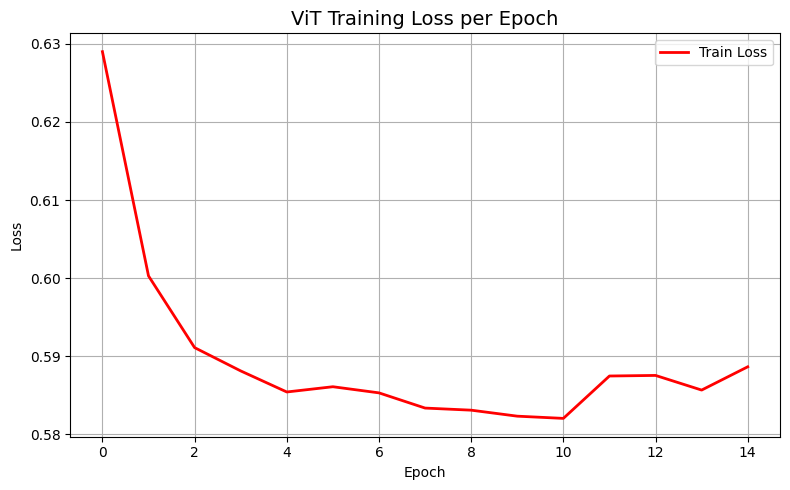

In [10]:
import matplotlib.pyplot as plt
import json

# ✅ Load training history for ViT
with open('/content/drive/MyDrive/ViT_scratch_history.json', 'r') as f:
    history = json.load(f)

# ✅ Plot Training Loss
plt.figure(figsize=(8, 5))
plt.plot(history['train_loss'], label='Train Loss', linewidth=2, color='red')
plt.title('ViT Training Loss per Epoch', fontsize=14)
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


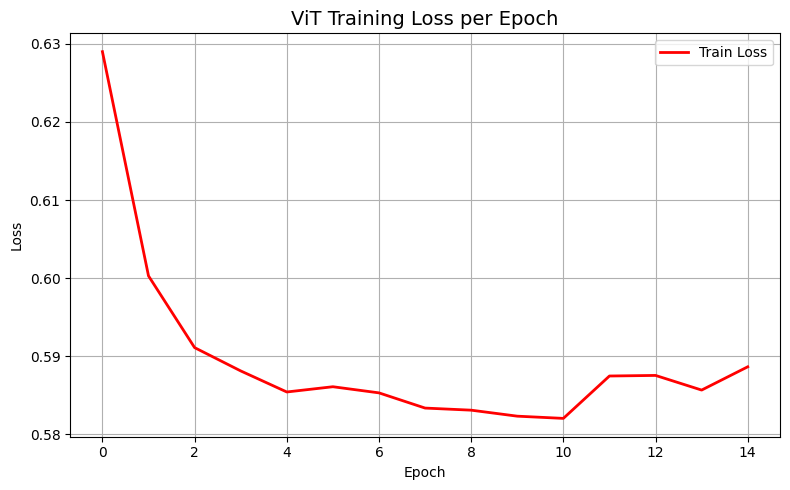

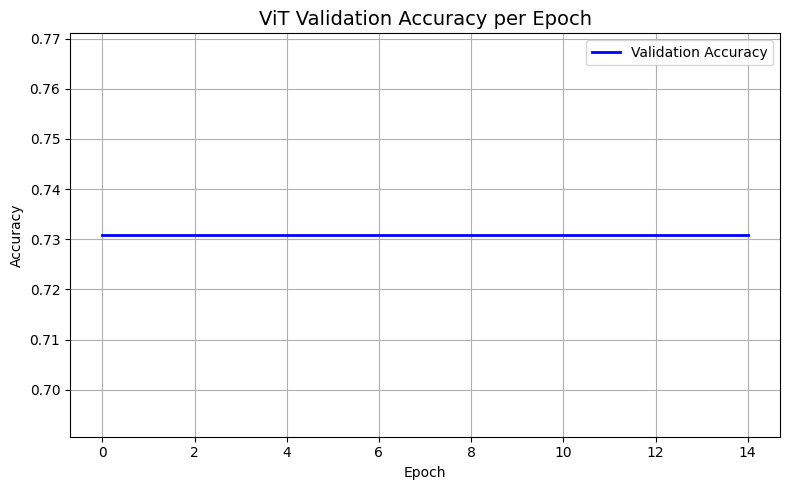

In [11]:
import matplotlib.pyplot as plt
import json

# ✅ Load ViT training history
with open('/content/drive/MyDrive/ViT_scratch_history.json', 'r') as f:
    history = json.load(f)

# ✅ Plot Training Loss
plt.figure(figsize=(8, 5))
plt.plot(history['train_loss'], label='Train Loss', color='red', linewidth=2)
plt.title('ViT Training Loss per Epoch', fontsize=14)
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# ✅ Plot Validation Accuracy
plt.figure(figsize=(8, 5))
plt.plot(history['val_accuracy'], label='Validation Accuracy', color='blue', linewidth=2)
plt.title('ViT Validation Accuracy per Epoch', fontsize=14)
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


In [17]:
import os, torch
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
from sklearn.metrics import accuracy_score, log_loss
from transformers import ViTConfig, ViTForImageClassification, ViTFeatureExtractor

# -------- CONFIG -------- #
base_path = '/content/drive/MyDrive/Medical_Data/archive/chest_xray/chest_xray_split'
model_path = '/content/drive/MyDrive/ViT_scratch_final.pth'
batch_size = 64
image_size = 224
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# -------- LOAD MODEL FROM CUSTOM CONFIG -------- #
config = ViTConfig(image_size=image_size, num_labels=2)
model = ViTForImageClassification(config)
model.load_state_dict(torch.load(model_path, map_location=device))
model.to(device)
model.eval()

# -------- TRANSFORM & EXTRACTOR -------- #
feature_extractor = ViTFeatureExtractor.from_pretrained("google/vit-base-patch16-224")
transform = transforms.Compose([
    transforms.Resize((image_size, image_size)),
    transforms.ToTensor()
])

# -------- LOAD TEST DATA -------- #
test_dataset = datasets.ImageFolder(os.path.join(base_path, 'test'), transform=transform)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

# -------- EVALUATE -------- #
all_preds, all_probs, all_labels = [], [], []

with torch.no_grad():
    for images, labels in test_loader:
        images, labels = images.to(device), labels.to(device)
        inputs = feature_extractor(images=images, return_tensors="pt").to(device)
        outputs = model(**inputs)
        probs = torch.softmax(outputs.logits, dim=1)
        preds = torch.argmax(probs, dim=1)
        all_preds.extend(preds.cpu().numpy())
        all_probs.extend(probs[:, 1].cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

# -------- METRICS -------- #
test_acc = accuracy_score(all_labels, all_preds)
test_loss = log_loss(all_labels, all_probs)

print(f"✅ Test Accuracy : {test_acc * 100:.2f}%")
print(f"📉 Test Loss     : {test_loss:.4f}")


/usr/local/lib/python3.11/dist-packages/transformers/models/vit/feature_extraction_vit.py:30: FutureWarning: The class ViTFeatureExtractor is deprecated and will be removed in version 5 of Transformers. Please use ViTImageProcessor instead.
  warnings.warn(


✅ Test Accuracy : 73.33%
📉 Test Loss     : 0.5808


/usr/local/lib/python3.11/dist-packages/transformers/models/vit/feature_extraction_vit.py:30: FutureWarning: The class ViTFeatureExtractor is deprecated and will be removed in version 5 of Transformers. Please use ViTImageProcessor instead.
  warnings.warn(


📊 Overall Model Performance (ViT):

✅ Accuracy :  0.7333
🎯 Precision: 0.7333
🔁 Recall   : 1.0000
📈 F1 Score : 0.8461


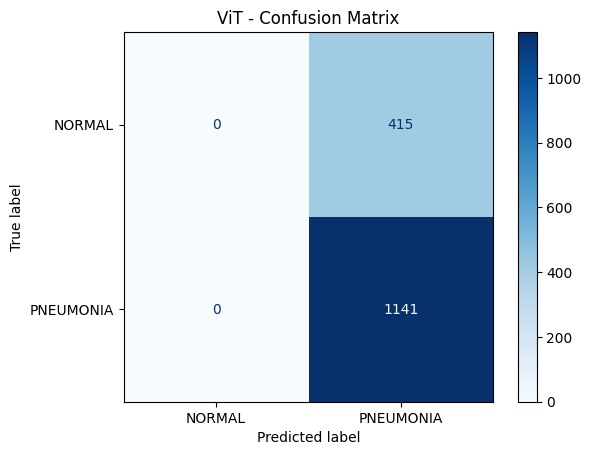


🧮 Confusion Matrix Breakdown:
✅ True Positives (TP): 1141
✅ True Negatives (TN): 0
❌ False Positives (FP): 415
❌ False Negatives (FN): 0


In [18]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score,
    confusion_matrix, ConfusionMatrixDisplay
)
import torch
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
from transformers import ViTConfig, ViTForImageClassification, ViTFeatureExtractor

# -------- CONFIG -------- #
base_path = '/content/drive/MyDrive/Medical_Data/archive/chest_xray/chest_xray_split'
model_path = '/content/drive/MyDrive/ViT_scratch_final.pth'
batch_size = 64
image_size = 224
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# -------- Load Model -------- #
config = ViTConfig(image_size=image_size, num_labels=2)
model = ViTForImageClassification(config)
model.load_state_dict(torch.load(model_path, map_location=device))
model.to(device)
model.eval()

# -------- Preprocessing -------- #
feature_extractor = ViTFeatureExtractor.from_pretrained("google/vit-base-patch16-224")
transform = transforms.Compose([
    transforms.Resize((image_size, image_size)),
    transforms.ToTensor()
])

# -------- Test Data -------- #
test_dataset = datasets.ImageFolder(f"{base_path}/test", transform=transform)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)
class_names = test_dataset.classes  # ['NORMAL', 'PNEUMONIA']

# -------- Inference -------- #
all_preds = []
all_labels = []

with torch.no_grad():
    for images, labels in test_loader:
        images, labels = images.to(device), labels.to(device)
        inputs = feature_extractor(images=images, return_tensors="pt").to(device)
        outputs = model(**inputs)
        probs = torch.softmax(outputs.logits, dim=1)
        preds = torch.argmax(probs, dim=1)
        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

y_true = np.array(all_labels)
y_pred = np.array(all_preds)

# -------- Metrics -------- #
overall_accuracy  = accuracy_score(y_true, y_pred)
overall_precision = precision_score(y_true, y_pred)
overall_recall    = recall_score(y_true, y_pred)
overall_f1        = f1_score(y_true, y_pred)

print("📊 Overall Model Performance (ViT):\n")
print(f"✅ Accuracy :  {overall_accuracy:.4f}")
print(f"🎯 Precision: {overall_precision:.4f}")
print(f"🔁 Recall   : {overall_recall:.4f}")
print(f"📈 F1 Score : {overall_f1:.4f}")

# -------- Confusion Matrix -------- #
cm = confusion_matrix(y_true, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_names)
disp.plot(cmap=plt.cm.Blues)
plt.title("ViT - Confusion Matrix")
plt.grid(False)
plt.show()

# -------- Breakdown -------- #
tn, fp, fn, tp = cm.ravel()
print("\n🧮 Confusion Matrix Breakdown:")
print(f"✅ True Positives (TP): {tp}")
print(f"✅ True Negatives (TN): {tn}")
print(f"❌ False Positives (FP): {fp}")
print(f"❌ False Negatives (FN): {fn}")
